# Zanim przystąpimy do ćwiczenia
* musimy sią upewnić, że mamy aktualną wersję biblioteki sklearn. Skrypt przygotowany jest dla wersji 0.19


In [5]:
import sklearn
print('Zainstalowana wersja scikit-learn: {}.'.format(sklearn.__version__))

Zainstalowana wersja scikit-learn: 0.19.1.


W procowni OKWF potrzebne będzie zainstalowanie lokalnego środowiska zgodnie z opisem:

https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/konfiguracja

Przyda się ono też do dalszych zajęć.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import diag, interp
from itertools import cycle

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Ćwiczenie: Walidacja krzyżowa 
* W tym ćwiczeniu przyjrzymy się jak miary jakości klasyfikatora zależą od proporcji klas w zbiorze uczącym i od rozmiaru zbioru uczącego
* Kaslyfikatorem będzie nadal regresja logistyczna, ale tym razem zaczniemy korzystać z wersji bibliotecznej z modułu [scikit-learn](http://scikit-learn.org/stable/index.html)


Funkcja do generowania danych:

In [7]:
def gen(ile):
    mu = [(-1,0.5),(1.2,4)] #średnie klas
    cov = [diag([3,3]), diag([4,1.7])] #macierze kowariancji dla klas
    
    X = np.zeros((ile*len(mu), 2)) # miejsce na dane wejściowe
    Y = np.zeros((ile*len(mu), 1),dtype = int) # miejsce na dane wyjściowe
    for klasa in range(len(mu)):
        X[klasa*ile:(klasa+1)*ile] = np.random.multivariate_normal(mu[klasa],cov[klasa],ile)
        Y[klasa*ile:(klasa+1)*ile] = klasa
    Y = Y.ravel()
    return (X,Y)

Testujemy tą funkcję, generujemy 50 przykładów, pierwszych 5 wypisujemy, wszystkie rysujemy za pomocą funkcji `scatter`:

X:  [[-3.06839559 -0.27746759]
 [ 0.18739208 -3.62206346]
 [-2.72919116  2.0793986 ]
 [-1.76860856 -0.6033659 ]
 [-4.71099356  3.49902146]]
Y:  [0 0 0 0 0]


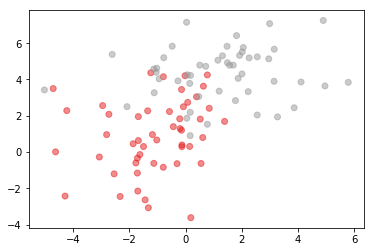

In [8]:
X,Y = gen(50)
print('X: ', X[0:5,:])
print('Y: ', Y[0:5])
plt.scatter(X[:,0], X[:,1] ,c = Y, cmap=plt.cm.Set1, alpha =0.5)
plt.show()

# Klasy równoliczne

## Zaobserwujmy zmienność miar jakości klasyfikatora przy wybieraniu podzbiorów do uczenia i testowania ze zbioru uczącego.
* do podziałów zbioru zastosujemy funkcję [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* do obliczania miar jakości zastosujemy funkcje z modułu [sklearn.metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

Wykonaj podział zbioru uczącego tak aby zestaw testowy stanowił 20% całego zbioru uczącego. Zilustruj za pomocą `scatter` punkty należące do częsści uczącej i dio części testowej:

* Podział:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= ...)

* Ilustracja:

In [ ]:
plt.scatter(X_train[:,0], X_train[:,1], c = y_train, cmap=plt.cm.Set1, alpha =0.5)
plt.scatter(X_test[:,0] , X_test[:,1],  c = y_test,  cmap=plt.cm.Set1, alpha =0.5, marker = '*' )
plt.show()

Regresja logistyczna zaimplementowana jest w klasie [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Tworzymy instancję obiektu tej klasy:

In [ ]:
lr = LogisticRegression()

Uczymy go  na zbiorze uczącym:

In [ ]:
lr.fit(X_train,y_train)

Wykonujemy predykcje dla zbioru testowego:

In [ ]:
y_pred = lr.predict(X_test)  

Efekty można obejrzeć za pomocą macierzy pomyłek: 

In [ ]:
print(metrics.confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print('TN: ',tn,'FP: ', fp, 'FN: ', fn, 'TP: ', tp )

W pętli powtórzymy proces podziału zbioru uczącego i dla każdego podziału obliczmy miary jakości:
* precyzja pozytywna: (positive predictive value (PPV), precision). Odpowiada na pytanie: "Jeśli wynik testu jest pozytywny, jakie jest prawdopodobieństwo, że osoba badana jest chora?"

$\qquad$ $PPV = \frac{TP}{P'}=\frac{TP}{ TP + FP}$

* czułość: Prawdopodobieństwo, że klasyfikacja będzie poprawna pod warunkiem, że przypadek jest pozytywny (ang. True Positive Rate, Recall). Jest to np. prawdopodobieństwo, że test wykonany dla osoby chorej wykaże, że jest ona chora.

$\qquad$ $TPR = \frac{TP}{ P} = \frac{TP} { TP+FN}$


* dokładność ( accuracy (ACC)): Prawdopodobieństwo prawidłowej klasyfikacji.

$\qquad$ $ACC = \frac{TP + TN}{P + N}$

* F1-score: średnia harmoniczna z precyzji i czułości:

$\qquad$ $F_1= 2 \frac{PPV  \cdot TPR}{PPV+TPR}= \frac{2TP}{ 2TP+FP+FN}$
Miara ta daje ocenę balansu między czułością a precyzją. Miara ta nie uwzględnia wyników prawdziwie negatywnych.

* współczynnik korelacji Matthews ( Matthews correlation coefficient):

$\qquad$ $
\text{MCC} = \frac{ TP \cdot TN - FP \cdot FN } {\sqrt{ (TP + FP) ( TP + FN ) ( TN + FP ) ( TN + FN ) } }
$

  * Ten współczynnik uwzględnia wyniki zarówno prawdziwie jaki i fałszywie pozytywne i negatywne i jest na ogół uważany jako zrównoważona miara, która może być stosowana nawet wtedy, gdy klasy są bardzo różnej liczebności. 
  * MCC jest w istocie współczynnikiem korelacji pomiędzy obserwowanymi i przewidywanymi klasyfikacjami binarnymi; zwraca wartość od -1 do +1. 
    * Współczynnik +1 odpowiada idealnej klasyfikacji, 
    * 0 nie lepiej niż losowe przypisanie wyniku i 
    * -1 oznacza całkowitą niezgodę między klasyfikacją  i stanem faktycznym.

In [ ]:
lr = LogisticRegression() # stwórz instancję klasyfikatora
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2 ) # podziel zbiór z 20% do testowania


    lr.fit( X_train, y_train ) # naucz klasyfikator
    y_pred = lr.predict(X_test) # wykonaj predykcję dla zbioru testowego
    
    
    PPV = metrics.precision_score(y_test, y_pred)
    REC = metrics.recall_score(y_test, y_pred)
    ACC = metrics.accuracy_score(y_test, y_pred)
    F1 = metrics.f1_score(y_test, y_pred)
    MCC = metrics.matthews_corrcoef(y_test, y_pred)
    
    print('PPV = {p:.3f} REC = {r:.3f} ACC = {a:.3f} F1 = {f:.3f} MCC =  {m:.3f}  '.format(a=ACC,f=F1,m=MCC,p=PPV,r=REC))

Widzimy, że miary zmieniają się przy każdym losowaniu.

Najczęściej stosuje się nie takie losowe podziały, ale systematyczny podział `k`-krotny (k-fold cross-validation). Procedura wygląda wówczas następująco:
* Dzielimy zbiór uczący (X i y) na `k` równych części
* Odkładamy 1-szą część jako dane testowe, 
* Na pozostałych `k-1` częściach uczymy klasyfikator
* Obliczamy miary jakości na tej odłożonej części
* Wybieramy 2-gą część jako dane testowe
* Na pozostałych `k-1` częściach uczymy klasyfikator
* Obliczamy miary jakości na tej odłożonej części
* $\vdots$

W bibliotece `sklearn` mamy do tego wygodną funkcję `cross_val_score`:

In [ ]:
from  sklearn.model_selection import cross_val_score

Zobaczmy jak działa:

In [ ]:
ppv = cross_val_score(lr, X, Y, cv=10, scoring='precision')
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(),ppv.std()))
rec = cross_val_score(lr, X, Y, cv=10, scoring='recall')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(lr, X, Y, cv=10, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(lr, X, Y, cv=10, scoring='f1')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))

Dla kompletu zbadajmy jeszcze krzywą ROC. Tym razem też posłużymy się funkcjami bibliotecznymi.

In [ ]:
skf  = StratifiedKFold(n_splits=6)
lr = LogisticRegression()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in skf.split(X, Y):
    lr.fit(X[train], Y[train]) # fitujemy regresję
    probas_ = lr.predict_proba(X[test]) # obliczamy prawdopodobieństwa przynależności przykładów testowych 
                                        # do klas wg. wyuczonego klasyfikatora 
                                        # (zwraca on w danym wierszu prawdopodobieństaw dla każdej z możliwych klas)
   
    # Obliczamy punkty krzywej ROC 
    fpr, tpr, thresholds = metrics.roc_curve(Y[test], probas_[:, 1]) # względem prawdopodobieństwa klasy 1 
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # i powierzchnię pod krzywą
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    # rysujemy krzywą 
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC dla podziału %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Losowa klasa', alpha=.8)
# poniżej podsumowanie: oliczanie średnich i standardowych odchyleń, cieniowanie przedziału ufności 
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Średni ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

Sprawdźmy jak miary jakości od rozmiaru zbioru uczącego:

In [ ]:
N = 10
PPV_mean = np.zeros((N,1))
PPV_std = np.zeros((N,1))
REC_mean = np.zeros((N,1))
REC_std = np.zeros((N,1))
ACC_mean = np.zeros((N,1))
ACC_std = np.zeros((N,1))
F1_mean = np.zeros((N,1))
F1_std = np.zeros((N,1))

n= 30+np.floor(np.logspace(1,4,N)).astype(int)

for i in range(N):
    X,Y = gen(int(n[i]))
    lr = LogisticRegression()
    ppv = cross_val_score( lr, X, Y, cv=10, scoring='precision' )
    PPV_mean[i] =ppv.mean()
    PPV_std[i]  = ppv.std()
    rec = cross_val_score( lr, X, Y, cv=10, scoring='recall' )
    REC_mean[i]  = rec.mean()
    REC_std[i]  = rec.std()
    acc = cross_val_score( lr, X, Y, cv=10, scoring='accuracy' )
    ACC_mean[i]  = acc.mean()
    ACC_std[i]  = acc.std()
    f1 = cross_val_score( lr, X, Y, cv=10, scoring='f1' )
    F1_mean[i]  = f1.mean()
    F1_std[i]  = f1.std()

ax = plt.subplot(1,1,1)
plt.errorbar(n,PPV_mean,yerr=PPV_std)
plt.errorbar(n+2,REC_mean,yerr=REC_std)
plt.errorbar(n+4,ACC_mean,yerr=ACC_std)
plt.errorbar(n+6,F1_mean,yerr=F1_std)
plt.legend(('PPV','REC','ACC','F1'))
ax.set_xscale("log", nonposx='clip')
plt.show()

## Klasy niezrównoważone

Wytwórzymy teraz dane w których jedna z klas jest M-krotnie liczniejsza. 

In [ ]:
def gen_rozne(ile, M):
    mu = [(-1,0.5),(1,4)]
    #mu = [(-1,0.5),(-1,0.5)]
    cov = [diag([1.7,1.8]), diag([1.5,0.7])]
    X = np.zeros(((M+1)*ile, 2)) # miejsce na dane wejściowe
    Y = np.zeros(((M+1)*ile, 1),dtype = int) # miejsce na dane wyjściowe
    print(Y.shape)
    klasa = 0
    X[0:ile] = np.random.multivariate_normal(mu[klasa],cov[klasa],ile)
    Y[0:ile] = klasa
    klasa =1 
    X[ile:ile+ile*M] = np.random.multivariate_normal(mu[klasa],cov[klasa],ile*M)
    Y[ile:ile+ile*M] = klasa
    Y = Y.ravel()
    print(np.sum(Y==0), np.sum(Y==1) )
    return (X,Y)

Oglądamy dane:

In [ ]:
X,Y = gen_rozne(30,100)
plt.scatter(X[:,0], X[:,1], c=Y, cmap=py.cm.Set1, alpha = 0.5)
plt.show()

Obliczamy miary jakości dla danych niezrównoważonych przy podziale 10-krotnym. Zwróćmy uwagę na różnicę w wartościach 4 pierwszych miar i miary MCC:

In [ ]:
lr = LogisticRegression()
ppv = cross_val_score( lr, X, Y, cv=10, scoring='precision' )
print( 'PPV = {0:.2f} +/- {1:.2f}'.format( ppv.mean(), ppv.std() ) )
rec = cross_val_score( lr, X, Y, cv=10, scoring='recall' )
print( 'REC = {0:.2f} +/- {1:.2f}'.format( rec.mean(), rec.std() ) )
acc = cross_val_score( lr, X, Y, cv=10, scoring='accuracy' )
print( 'ACC = {0:.2f} +/- {1:.2f}'.format( acc.mean(), acc.std() ) )
f1 = cross_val_score( lr, X, Y, cv=10, scoring='f1' )
print( 'F1 = {0:.2f} +/- {1:.2f}'.format( f1.mean(), f1.std() ) )

print('-----')

MCC=np.zeros((10,1))
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1) # test na 10% aby było podobnie jak dla podziału 10-krotnego
    lr.fit( X_train, y_train ) # trenuj model
    y_pred = lr.predict(X_test) # predykcja dla zbioru testowego
    MCC[i] = metrics.matthews_corrcoef(y_test, y_pred)
print('MCC = {0:.2f} +/- {1:.2f}'.format(MCC.mean(),MCC.std()))  
   

Teraz spróbujemy zobaczyć czy da się to poprawić jeśli w podziałach zadbać o zachowanie proporcji klas. Można to łatwo zrobić za pomocą funkcji `StratifiedKFold` , zwraca ona indeksy do zbiru treningowego i testowego:

In [ ]:
skf = StratifiedKFold(n_splits=4)
for train, test in skf.split(X, Y):  
    lr.fit(X[train,:],Y[train])
    y_pred = lr.predict(X[test,:]) 
    y_test = Y[test]
    PPV = metrics.precision_score(y_test, y_pred)
    REC = metrics.recall_score(y_test, y_pred)
    ACC = metrics.accuracy_score(y_test, y_pred)
    F1 = metrics.f1_score(y_test, y_pred)
    MCC = metrics.matthews_corrcoef(y_test, y_pred)
    
    print('PPV = {p:.3f} REC = {r:.3f} ACC = {a:.3f} F1 = {f:.3f} MCC =  {m:.3f}  '.format(a=ACC,f=F1,m=MCC,p=PPV,r=REC))

Zbadajmy jeszcze krzywą ROC:

In [ ]:
skf  = StratifiedKFold(n_splits=6)
lr = LogisticRegression()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
    lr.fit(X[train],Y[train]) # fitujemy regresję
    probas_ = lr.predict_proba(X[test]) # obliczamy prawdopodobieństwa przynależności przykładów testowych 
                                        # do klas wg. wyuczonego klasyfikatora 
                                        # (zwraca on w danym wierszu prawdopodobieństaw dla każdej z możliwych klas)
     
    # Obliczamy punkty krzywej ROC 
    fpr, tpr, thresholds = metrics.roc_curve(Y[test], probas_[:, 1]) # względem prawdopodobieństwa klasy 1 
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # i powierzchnię pod krzywą
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    # rysujemy krzywą 
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC dla podziału %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Losowa klasa', alpha=.8)
# poniżej podsumowanie: oliczanie średnich i standardowych odchyleń, cieniowanie przedziału ufności 
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Średni ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

Powyższe obliczenia obliczenia proszę przeprowadzić dla klas, których rozkłądy wyraźnie się różnią i dla takich które się pokrywają w znacznym stopniu. Trzeba podmienić średnie klas w funkcji generującej dane różnoliczne.

## Jaki stąd płynie wniosek?
